### The Building blocks of CNNs

conv architectures are often described as feature extraction layers

### Understanding CNNs and feature heirarchies

CNNs can automatically learn the features from raw data that are 
most useful for a particular task. so it's common to consider CNN
layers as feature extractors. 

these are the first layers and later their findings are exploited by 
fully connected layers/MLPs. 

feature heirarchy: constructed by deep CNNs where they combine 
low level features in a layer wise fashion to form high level features
for example, edges and blobs extracted from earlier layers are 
combined to form high level features. these high level features can 
form more complex shapes

local receptive field: local patch of pixels which correspond to only one element of the feature matrix.

cnns work well because of two ideas
1. sparse connnectivity: opposed to fully connected layers where each pixel
is connected to the hidden nodes, only a selected pixels are connected to each node in the feature map. 
2. parameter sharing: same weights are used for different patches of the input image. 

as a result, using a convolution layer substantially reduces the number of weights. 
it makes sense to assume nearby pixels are correlated in an image. 
it improves the ability to capture salient features.

typical cnn has several convolution and subsampling layer with fully connected layers at the end. 
these subsampling layers are also called pooling layers and have no parameters. only the convolution layers
and the fully connected layers have learnable parameters. 

### Performing discrete convolutions

fundamental operation in a cnn

a discrete convolution for two vectors x and w is denoted by y = x * w. x is the input and w is the filter/kernel. 
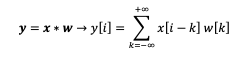

here the summation runs from negative infinite to infinite. in machine learning, we only work with finite 
feature vectors. so this is not useful in practical application. in practice, x is padded with a finite 
number of zeros. 

this is called zero-padding. 

so if x originally had n elements, the padded x would have n+2p (2 p because p zeros are padded on each side)

now the equation becomes

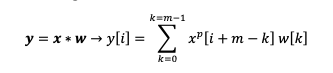

ßß